# 3. Long Short-Term Memory (LSTM) Model

In this notebook, a long short-term memory (LSTM) model will be created with several different layers to generate an abstractive summary of a given text.

IMPORTANT: In Google Colab, change the Runtime Option to CPU and enable High Ram
If possible use the GPU with high ram

In [34]:
# don't need to run this code if not on Google Colab
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
!git clone https://github.com/thushv89/attention_keras.git

fatal: destination path 'attention_keras' already exists and is not an empty directory.


In [36]:
# from attention import AttentionLayer
from attention_keras.src.layers.attention import AttentionLayer

In [37]:
import pandas as pd
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, TimeDistributed, Flatten, Conv2D, MaxPooling2D, Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings

tf.config.run_functions_eagerly(True)
warnings.filterwarnings(action='ignore')

In [38]:
# import data
df = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/AAI590_Capstone/Datasets/podcast_with_summary_train.csv')
df.head()

,text,summary
0,"The following is a conversation with Yosha Bach, his second time on the podcast. Yosha is one of the most fascinating minds in the world, exploring the nature of intelligence, cognition, computati...",the system is extracting information at different levels of abstraction and context and then synthesizing them to generate more comprehensive and coherent outputs. This multi-resolution approach ...
1,"The following is a conversation with John Hopfield, professor at Princeton, whose life's work weaved beautifully through biology, chemistry, neuroscience, and physics. Most crucially, he saw the m...","John Hopfield, a professor at Princeton, discusses his work on associative neural networks, now known as Hopfield networks, and the importance of feedback systems in understanding complex biologic..."
2,"The following is a conversation with Ilya Sotskever, cofounder and chief scientist of OpenAI, one of the most cited computer scientists in history with over 165,000 citations, and to me, one of th...","Ilya Sotskever, co-founder of OpenAI, discusses the remarkable success of deep learning and its unification of different domains within artificial intelligence. He highlights the beautiful simplic..."
3,"The following is a conversation with Travis Oliphant, one of the most impactful programmers and data scientists ever. He created NumPy, SciPy, and Anaconda. NumPy formed the foundation of tensor b...","The conversation with Travis Oliphant shares insights on his impactful work with NumPy, SciPy, and Anaconda. He discusses his first steps in basic programming, philosophy of design and leadership,..."
4,"Well, the source of energy at the origin of life is the reaction between carbon dioxide and hydrogen. And amazingly, most of these reactions are exergonic, which is to say they release energy. If ...",ally feel sad or not is a whole other question. But the fact that it's able to engage in that kind of complex interaction is what will make it seem like a conscious being to us. And I think that's...


In [39]:
df['summary'].iloc[0]

' the system is extracting information at different levels of abstraction and context and then synthesizing them to generate more comprehensive and coherent outputs. This multi-resolution approach could potentially address the limitations of GPT3 and enable the system to have a more robust and scalable memory system.'

In [40]:
# create mapping of unique chars to integers
chars = sorted(list(set(df['summary'].iloc[0])))
char_to_int = dict((c, i) for i, c in enumerate(chars))

In [41]:
from transformers import AutoTokenizer

model_checkpoint = "google/mt5-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [42]:
df.loc[0]

,0
text,"The following is a conversation with Yosha Bach, his second time on the podcast. Yosha is one of the most fascinating minds in the world, exploring the nature of intelligence, cognition, computati..."
summary,the system is extracting information at different levels of abstraction and context and then synthesizing them to generate more comprehensive and coherent outputs. This multi-resolution approach ...


In [43]:
inputs = tokenizer(df['text'][0])
with tokenizer.as_target_tokenizer():
  targets = tokenizer(df['summary'][0])

In [44]:
print(tokenizer.convert_ids_to_tokens(inputs["input_ids"]))
print(tokenizer.convert_ids_to_tokens(targets["input_ids"]))

['▁The', '▁', 'following', '▁is', '▁', 'a', '▁conversation', '▁with', '▁', 'Yosh', 'a', '▁Bach', ',', '▁his', '▁second', '▁time', '▁on', '▁the', '▁podcast', '.', '▁', 'Yosh', 'a', '▁is', '▁one', '▁of', '▁the', '▁most', '▁fascina', 'ting', '▁mind', 's', '▁in', '▁the', '▁world', ',', '▁explor', 'ing', '▁the', '▁nature', '▁of', '▁', 'intelligence', ',', '▁', 'cognition', ',', '▁', 'com', 'putation', ',', '▁and', '▁c', 'onsciousness', '.', '▁To', '▁support', '▁this', '▁podcast', ',', '▁please', '▁check', '▁out', '▁our', '▁', 'sponsors', ',', '▁Coin', 'base', ',', '▁Co', 'decade', 'my', ',', '▁Li', 'node', ',', '▁Net', 'Suite', ',', '▁and', '▁Express', 'VPN', '.', '▁The', 'ir', '▁links', '▁are', '▁in', '▁the', '▁description', '.', '▁This', '▁is', '▁the', '▁Lex', '▁Fried', 'man', '▁podcast', ',', '▁and', '▁here', '▁is', '▁my', '▁conversation', '▁with', '▁', 'Yosh', 'a', '▁Bach', '.', '▁Thank', '▁you', '▁for', '▁', 'once', '▁again', '▁', 'coming', '▁on', '▁to', '▁this', '▁particular', '▁Russi

In [45]:
max_input_length = 512
max_target_length = 30
df_len = len(df['summary'])


def tokenize_dataset(df, df_length):
  inputs_list = []
  targets_list = []
  for i in range(df_length):
    inputs = tokenizer(df['text'][i])
    with tokenizer.as_target_tokenizer():
      targets = tokenizer(df['summary'][i])
    inputs_list.append(inputs)
    targets_list.append(targets)

  df['text_tokenized'] = inputs_list
  df['summary_tokenized'] = targets_list

  return df

In [46]:
tokenize_dataset(df,df_len)

,text,summary,text_tokenized,summary_tokenized
0,"The following is a conversation with Yosha Bach, his second time on the podcast. Yosha is one of the most fascinating minds in the world, exploring the nature of intelligence, cognition, computati...",the system is extracting information at different levels of abstraction and context and then synthesizing them to generate more comprehensive and coherent outputs. This multi-resolution approach ...,"[input_ids, attention_mask]","[input_ids, attention_mask]"
1,"The following is a conversation with John Hopfield, professor at Princeton, whose life's work weaved beautifully through biology, chemistry, neuroscience, and physics. Most crucially, he saw the m...","John Hopfield, a professor at Princeton, discusses his work on associative neural networks, now known as Hopfield networks, and the importance of feedback systems in understanding complex biologic...","[input_ids, attention_mask]","[input_ids, attention_mask]"
2,"The following is a conversation with Ilya Sotskever, cofounder and chief scientist of OpenAI, one of the most cited computer scientists in history with over 165,000 citations, and to me, one of th...","Ilya Sotskever, co-founder of OpenAI, discusses the remarkable success of deep learning and its unification of different domains within artificial intelligence. He highlights the beautiful simplic...","[input_ids, attention_mask]","[input_ids, attention_mask]"
3,"The following is a conversation with Travis Oliphant, one of the most impactful programmers and data scientists ever. He created NumPy, SciPy, and Anaconda. NumPy formed the foundation of tensor b...","The conversation with Travis Oliphant shares insights on his impactful work with NumPy, SciPy, and Anaconda. He discusses his first steps in basic programming, philosophy of design and leadership,...","[input_ids, attention_mask]","[input_ids, attention_mask]"
4,"Well, the source of energy at the origin of life is the reaction between carbon dioxide and hydrogen. And amazingly, most of these reactions are exergonic, which is to say they release energy. If ...",ally feel sad or not is a whole other question. But the fact that it's able to engage in that kind of complex interaction is what will make it seem like a conscious being to us. And I think that's...,"[input_ids, attention_mask]","[input_ids, attention_mask]"
...,...,...,...,...
250,The following is a conversation with David Sinclair. He's a professor in the Department of Genetics at Harvard and co director of the Paul F. Glenn Center for the Biology of Aging at Harvard Medic...,"So, we can think of a scenario where we can preserve that degradation of information over time by either slowing down the scratches on the DVD or potentially creating a back-up repository for the ...","[input_ids, attention_mask]","[input_ids, attention_mask]"
251,"The following is a conversation with Vladimir Vapnik, part two, the second time we spoke on the podcast. He's the coinventor of support vector machines, support vector clustering, VC theory, and m...",ds to a small set. But then it's more about finding those few good predicates rather than a brute force exploration of all possible predicates. And that's where the challenge lies in coming up wit...,"[input_ids, attention_mask]","[input_ids, attention_mask]"
252,"The following is a conversation with Peter Singer, professor of bioethics at Princeton University, best known for his 1975 book, Animal Liberation, that makes an ethical case against eating meat. ...","The conversation with Peter Singer delves into ethical considerations, including animal rights, effective altruism, and AI ethics. Singer emphasizes the importance of reducing suffering and the ne...","[input_ids, attention_mask]","[input_ids, attention_mask]"
253,What are your thoughts on the ongoing war in Ukraine? How do you analyze it within your framework about war? How far would they go to hang onto power when push came to shove is I think the thing t...,"y o

In [50]:
model_inputs = tokenizer(
        df["summary"].iloc[0],
        max_length=max_input_length,
        truncation=True,
    )
model_inputs

{'input_ids': [287, 2974, 339, 45121, 347, 2883, 344, 5673, 259, 16241, 304, 83949, 2457, 305, 19730, 305, 4875, 177515, 50269, 2486, 288, 259, 66792, 1097, 317, 61442, 305, 964, 118990, 37437, 263, 260, 1494, 5942, 264, 231029, 18996, 259, 3659, 19497, 484, 14130, 287, 7674, 6540, 304, 489, 11620, 328, 305, 259, 38195, 287, 2974, 288, 783, 259, 262, 1097, 46366, 305, 53431, 1059, 28246, 2974, 260, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [51]:
x_tr,x_val,y_tr,y_val=train_test_split(df['text'],df['summary'],test_size=0.1,random_state=0,shuffle=True)

In [52]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


max_text_len=1000
max_summary_len=100

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr)
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  len(x_tokenizer.word_index) + 1

In [53]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr)
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   len(y_tokenizer.word_index) + 1

In [54]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
#from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [55]:
#from keras import backend as K
#K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 1000)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, 1000, 100)      │      4,406,900 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_8 (LSTM)             │ [(None, 1000, 300),    │        481,200 │ embedding_4[0][0]      │
│                           │ (None, 300), (None,    │                │                        │
│                           │ 300)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_5             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_9 (LSTM)             │ [(None, 1000, 300),    │        721,200 │ lstm_8[0][0]           │
│                           │ (None, 300), (None,    │                │                        │
│                           │ 300)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_5 (Embedding)   │ (None, None, 100)      │        574,700 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_10 (LSTM)            │ [(None, 1000, 300),    │        721,200 │ lstm_9[0][0]           │
│                           │ (None, 300), (None,    │                │                        │
│                           │ 300)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_11 (LSTM)            │ [(None, None, 300),    │        481,200 │ embedding_5[0][0],     │
│                           │ (None, 300), (None,    │                │ lstm_10[0][1],         │
│                           │ 300)]                  │                │ lstm_10[0][2]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ [(None, None, 300),    │        180,300 │ lstm_10[0][0],         │
│ (AttentionLayer)          │ (None, None, 1000)]    │                │ lstm_11[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat_layer              │ (None, None, 600)      │              0 │ lstm_11[0][0],         │
│ (Concatenate)             │                        │                │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_2        │ (None, None, 5747)     │      3,453,947 │ concat_layer[0][0]     │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 11,020,647 (42.04 MB)

 Trainable params: 11,020,647 (42.04 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [57]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [58]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=64, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 279s 66s/step - loss: 8.6363 - val_loss: 8.4201
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 261s 65s/step - loss: 7.8451 - val_loss: 7.0246
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 262s 66s/step - loss: 6.3235 - val_loss: 5.3679
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 265s 66s/step - loss: 5.5793 - val_loss: 5.1976
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 260s 65s/step - loss: 5.3718 - val_loss: 5.0424
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 256s 64s/step - loss: 5.2931 - val_loss: 4.9297
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 255s 64s/step - loss: 5.2082 - val_loss: 4.8515
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 257s 64s/step - loss: 5.0380 - val_loss: 4.8297
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 257s 64s/step - loss: 4.9566 - val_loss: 4.8199
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 255s 64s/step - loss: 5.0470 - val_loss: 4.7985
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 255s 64s/step - loss: 4.9941 - val_loss: 4.7950
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 256s 64s/step - loss: 4.9797 - val_lo

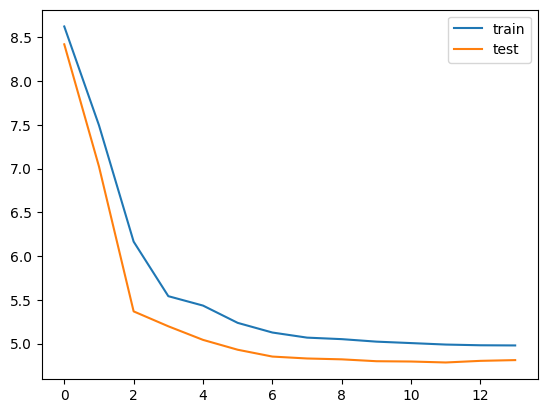

In [59]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [60]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [61]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [66]:
start_token = 'following'
end_token = 'conversation'

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index[start_token]

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!=end_token):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == end_token  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [67]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index[start_token]) and i!=target_word_index[end_token]):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [68]:
for i in range(0,10):
    print("Original text:",seq2text(x_tr[i]))
    # print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Original text: day endurance wise that's okay yeah i think that's fine like you will have free days as well so i don't think that will be a problem and also you have to prepare two sets of openings for each day which makes it more difficult for the teams preparing which i think is also good let me ask you a fun question if hikaru nakamura was one of the two people i guess i apologize yeah he could have finished second so he lost the last round of the candidates yeah and maybe you can explain to me internet speed copium is something you tweeted yeah but if he got second would you just despite him still play the world championship that's internet question and when the internet asks i must abide the dude abides yeah sure thank you internet so after the last match i did an interview right after where i talked about the fact that i was unlikely to play the next one i'd spoken privately to both family friends and of course also my chess team that this was likely going to be the last match wh